# Importing Required Libraries

In [15]:
import tensorflow as tf
import keras
print("Keras Version : ",keras.__version__)
print("Tensorflow Version : ",tf.__version__)
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import efficientnet.keras as efn
import keras.backend as K
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import albumentations as albu
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix
from google.colab import drive
drive.mount('/content/gdrive')
from google.colab import files
import pandas as pd
from pylab import rcParams

Keras Version :  2.3.1
Tensorflow Version :  2.0.0
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Model Parameters

In [2]:
# parameters for data
height = 224
width = 224
channels = 3
input_shape = (height, width, channels)
n_classes = 100
# parameters for optimizers
lr = 0.001
# Parameters for training
epochs = 25
batch_size = 8
# parameters for callback functions
es_patience = 10
rlrop_patience = 5
decay_rate = 0.5

# Loading Cifar100 data

In [4]:
(X, y), (X_test, y_test) = cifar100.load_data()

print("The shape of X_train : ", X.shape)
print("The shape of X_test : ", X_test.shape)
print("The shape of y_train : ", y.shape)
print("The shape of y_test : ", y_test.shape)

# Cifar 100 labels
fine_label_list =  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed',
                    'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 
                    'bridge', 'bus', 'butterfly','camel', 'can', 'castle',
                    'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
                    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
                    'dinosaur', 'dolphin', 'elephant', 'flatensorflowish',
                    'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo',
                    'computer_keyboard','lamp', 'lawn_mower', 'leopard', 'lion',
                    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle',
                    'mountain', 'mouse', 'mushroom','oak_tree', 'orange', 
                    'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck',
                    'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
                    'possum','rabbit', 'raccoon', 'ray', 'road', 'rocket',
                    'rose','sea', 'seal', 'shark', 'shrew', 'skunk', 
                    'skyscraper', 'snail', 'snake', 'spider', 'squirrel',
                    'streetcar', 'sunflower', 'sweet_pepper','table', 'tank',
                    'telephone', 'television', 'tiger', 'tractor', 'train',
                    'trout', 'tulip', 'turtle','wardrobe', 'whale', 
                    'willow_tree', 'wolf', 'woman', 'worm']   

The shape of X_train :  (50000, 32, 32, 3)
The shape of X_test :  (10000, 32, 32, 3)
The shape of y_train :  (50000, 1)
The shape of y_test :  (10000, 1)


# Preprocessing Data

In [5]:
def unison_shuffled_copies(a, b):
  randomize = np.arange(len(a))
  np.random.shuffle(randomize)
  x = a[randomize]
  y = b[randomize]
  return x, y

# Shuffling dataset
X, y = unison_shuffled_copies(X, y)
X_test, y_test = unison_shuffled_copies(X_test, y_test)

# Spliting the training data into a training data and a validation data.
st = StratifiedShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 1)
for train_index, val_index in st.split(X, y):
    X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]
    
print("The number of training data : ", X_train.shape[0])
print("The number of validation data : ", X_val.shape[0])

The number of training data :  40000
The number of validation data :  10000


# Visualizing Some Samples

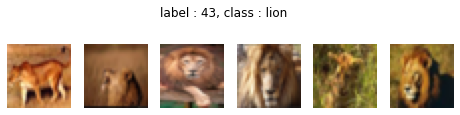

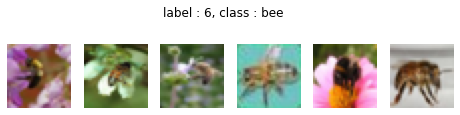

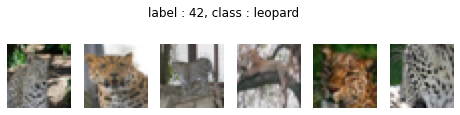

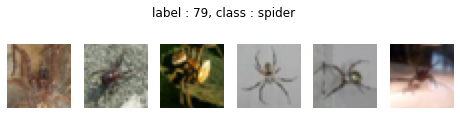

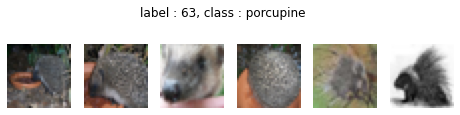

In [6]:
num_classes= 5 # Number of classes visualized
num_samples= 6 # Number of samples from each class
class_plotted = np.random.choice(range(n_classes),num_classes, replace = False)
for i in range(len(class_plotted)):
    image_samples = X[y.reshape(-1) == class_plotted[i]][:num_samples]
    fig, ax = plt.subplots(nrows = 1, ncols = num_samples,figsize=(8,2) )
    fig.suptitle("label : %d, class : %s" % (class_plotted[i],
                                             fine_label_list[class_plotted[i]]))
    for j in range(num_samples):
        ax[j].imshow(image_samples[j])
        ax[j].axis('off') 

plt.show()

# Image Augmentation

In [7]:
def np_resize(img, shape):
    return cv2.resize(img, (shape[1], shape[0]), interpolation = cv2.INTER_CUBIC)

class DataGenerator(keras.utils.Sequence):
    'Generates data for keras'
    def __init__(self, images , labels = None, mode = 'fit', batch_size = batch_size,
                 dim = (height, width), channels = channels, n_classes = n_classes,
                 shuffle = True, augment = False):
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))
        
    def __getitem__(self, index):
        'Generate one batch of data'
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # =========================================================== #
        # Generate mini-batch of X
        # =========================================================== #
        X = np.empty((self.batch_size, *self.dim, self.channels))
        for i, ID in enumerate(batch_indexes):
            # Generate a preprocessed image
            img = self.images[ID]
            img = img.astype(np.float32) / 255.
            img = np_resize(img, self.dim)
            X[i] = img
            
        
        # =========================================================== #
        # Generate mini-batch of y
        # =========================================================== #
        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            y = to_categorical(y, n_classes)
            '''
            y = np.zeros((self.batch_size, self.n_classes), dtype = np.uint8)
            for i, ID in enumerate(batch_indexes):
                # one hot encoded label
                y[i, self.labels[ID]] = 1
            '''
            # Augmentation should only be implemented in the training part.
            if self.augment == True:
                X = self.__augment_batch(X)                
            
            return X,y
        
        elif self.mode == 'predict':
            return X       
        
        else:
            raise AttributeError('The mode parameters should be set to "fit" or "predict"')
            
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p = 0.5),
                                    albu.VerticalFlip(p = 0.5),
                                    albu.GridDistortion(p = 0.2),
                                    albu.ElasticTransform(p = 0.2)])
        
        return composition(image = img)['image']
        
    
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])
            
        return img_batch

train_generator = DataGenerator(X_train, y_train, augment = True)
valid_generator = DataGenerator(X_val, y_val, augment = False)

# Building and Compiling Network

In [9]:
efnb0 = efn.EfficientNetB0(weights = 'imagenet', include_top = False, 
                           classes = n_classes, input_shape = input_shape)


model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation = 'softmax'))

model.summary()

efnb0.trainable = False
opt = SGD(learning_rate = lr, momentum = 0.9, nesterov = True)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, 
              metrics = ['acc'])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               128100    
Total params: 4,177,664
Trainable params: 4,135,648
Non-trainable params: 42,016
_________________________________________________________________


# Training Model

In [ ]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = es_patience,
                   restore_best_weights = True, verbose = 1)
rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', 
                          patience = rlrop_patience, factor = decay_rate,
                          min_lr = 1e-6, verbose = 1)

data_dir1 = '/content/gdrive/My Drive/Vision_Project/CNN_TL/CNN_TL_checkpoint.hdf5'
checkpoint = ModelCheckpoint(filepath=data_dir1, monitor='loss' , verbose=1,
                             save_best_only=True, mode='min')

hist = model.fit(train_generator,validation_data = valid_generator, 
                 epochs= epochs, verbose= 1, callbacks= [es, rlrop, checkpoint])

model.save_weights("/content/gdrive/My Drive/Vision_Project/CNN_TL/CNN_TL_weights.hdf5")
model.save("/content/gdrive/My Drive/Vision_Project/CNN_TL/CNN_TL_model.hdf5")

# Resuming a Pre-Trained Model

In [12]:
model.load_weights('/content/gdrive/My Drive/Vision_Project/CNN_TL/CNN_TL_weight.hdf5')

es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = es_patience,
                   restore_best_weights = True, verbose = 1)
rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', 
                          patience = rlrop_patience, factor = decay_rate,
                          min_lr = 1e-6, verbose = 1)

data_dir1 = '/content/gdrive/My Drive/Vision_Project/CNN_TL/CNN_TL_checkpoint.hdf5'
checkpoint = ModelCheckpoint(filepath=data_dir1, monitor='loss' , verbose=1,
                             save_best_only=True, mode='min')

hist = model.fit(train_generator,validation_data = valid_generator, epochs = 25,
                 verbose= 1, initial_epoch= 24, callbacks= [es, rlrop, checkpoint])

model.save_weights("/content/gdrive/My Drive/Vision_Project/CNN_TL/CNN_TL_weight.hdf5")
model.save("/content/gdrive/My Drive/Vision_Project/CNN_TL/CNN_TL_model.hdf5")

Epoch 25/25
5000/5000 [==============================] - 5165s 1s/step - loss: 0.6305 - acc: 0.8128 - val_loss: 0.0780 - val_acc: 0.9134

Epoch 00025: loss improved from inf to 0.63050, saving model to /content/gdrive/My Drive/Vision_Project/CNN_TL/CNN_TL_checkpoint.hdf5


# Testing Model

In [16]:
test_generator = DataGenerator(X_test, y_test, augment = False)
test_loss, test_accuracy = model.evaluate(test_generator)
y_pred = model.predict(test_generator)

y_pred2=[]
for i in range(len(y_pred)):
  y_pred2.append( np.argmax(y_pred[i]) )
  
test_accuracy *=  100

print(classification_report(y_test, y_pred2))
print("Accuracy: "+str(test_accuracy)+ " %")
print('\n')

              precision    recall  f1-score   support

           0       0.03      0.03      0.03       100
           1       0.04      0.04      0.04       100
           2       0.01      0.01      0.01       100
           3       0.01      0.01      0.01       100
           4       0.01      0.01      0.01       100
           5       0.00      0.00      0.00       100
           6       0.00      0.00      0.00       100
           7       0.00      0.00      0.00       100
           8       0.01      0.01      0.01       100
           9       0.00      0.00      0.00       100
          10       0.01      0.01      0.01       100
          11       0.00      0.00      0.00       100
          12       0.02      0.02      0.02       100
          13       0.03      0.03      0.03       100
          14       0.00      0.00      0.00       100
          15       0.01      0.01      0.01       100
          16       0.00      0.00      0.00       100
          17       0.00    

# Test Metrics

In [17]:
conf_matrix = confusion_matrix(y_true= y_test, y_pred= y_pred2)
                               
FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

ids = ['TP rate', 'TN rate',  'Precision',  'N prediction value', 
       'FP rate', 'FN rate' ,'FD rate', 'Acc']


df = pd.DataFrame( { 'TP': TP.round(3)
                   , 'TN': TN.round(3)
                   , 'FN': FN.round(3)
                   , 'FP': FP.round(3)
                   , ids[7]: ACC.round(3) 
                   , ids[0]: TPR.round(3)
                   , ids[1]: TNR.round(3)
                   , ids[2]: PPV.round(3)
                   , ids[4]: FDR.round(3)
                   , ids[5]: FNR.round(3)
                   , ids[6]: FDR.round(3)
                   , ids[3]: NPV.round(3)  }
                  , index = fine_label_list  
                  )
df

,TP,TN,FN,FP,Acc,TP rate,TN rate,Precision,FP rate,FN rate,FD rate,N prediction value
apple,3,9791,97,109,0.979,0.03,0.989,0.027,0.973,0.97,0.973,0.99
aquarium_fish,4,9802,96,98,0.981,0.04,0.990,0.039,0.961,0.96,0.961,0.99
baby,1,9761,99,139,0.976,0.01,0.986,0.007,0.993,0.99,0.993,0.99
bear,1,9809,99,91,0.981,0.01,0.991,0.011,0.989,0.99,0.989,0.99
beaver,1,9803,99,97,0.980,0.01,0.990,0.010,0.990,0.99,0.990,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...
whale,0,9795,100,105,0.980,0.00,0.989,0.000,1.000,1.00,1.000,0.99
willow_tree,1,9820,99,80,0.982,0.01,0.992,0.012,0.988,0.99,0.988,0.99
wolf,1,9793,99,107,0.979,0.01,0.989,0.009,0.991,0.99,0.991,0.99
woman,2,9789,98,111,0.979,0.02,0.989,0.018,0.982,0.98,0.982,0.99


# Visualizing Performance

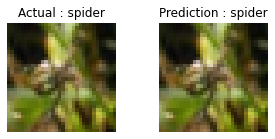

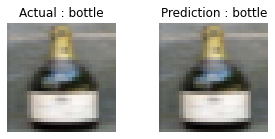

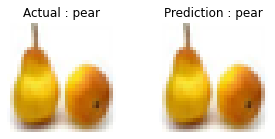

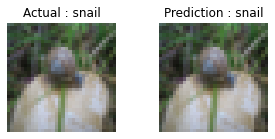

In [34]:
n_tests = 4
start = 15

image = test_generator.images[start: start + n_tests]
labels = y_test[start: start + n_tests]

pred = y_pred2[start: start + n_tests]

for i in range(len(labels)):
  fig, (ax1, ax2) = plt.subplots(1, 2 , figsize=(5, 2))
  ax1.axis('off')
  ax1.imshow(image[i] , cmap=plt.cm.gray)
  ax1.set_title("Actual : " + str(fine_label_list[int(labels[i]) ]) )
  ax2.axis('off')
  ax2.imshow(image[i], cmap=plt.cm.gray)
  ax2.set_title('Prediction : '+ str( fine_label_list[int(pred[i] )] ))

plt.show()

# Graphing Test Accuracy

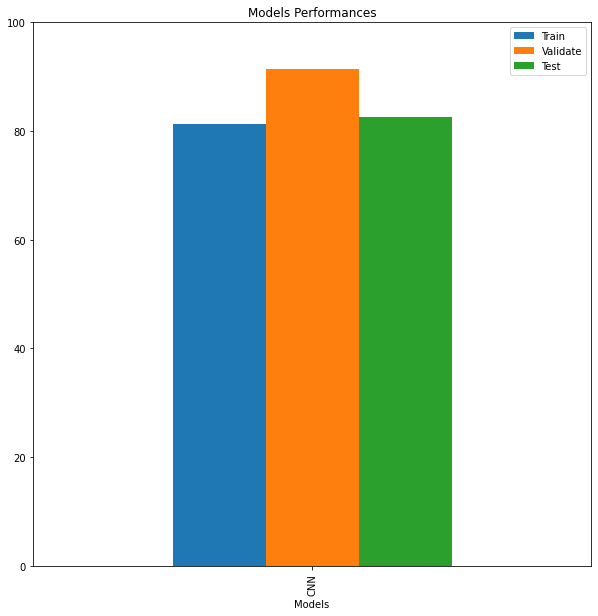

In [38]:
df = pd.DataFrame([['CNN',
                    hist.history["acc"][-1]*100 ,
                    hist.history["val_acc"][-1]*100, test_accuracy]],
                  columns=['Models', 'Train', 'Validate', 'Test'])
df.plot(x='Models',
        kind='bar',
        stacked=False,
        figsize=(10,10),
        ylim=(0,100),
        title='Models Performances')